In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
building_df = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
train_df = pd.read_csv("../input/ashrae-energy-prediction/train.csv")
weather_train_df = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")

In [4]:
building_df = reduce_mem_usage(building_df)
train_df = reduce_mem_usage(train_df)
weather_train_df = reduce_mem_usage(weather_train_df)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [5]:
building_merge_train_df = train_df.merge(building_df, on='building_id', how='left')
df_train = building_merge_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

In [6]:
import gc
del train_df
del building_df
del weather_train_df
gc.collect()

0

In [7]:
df_train["timestamp"] = pd.to_datetime(df_train["timestamp"])
df_train["hour"] = df_train["timestamp"].dt.hour
df_train["day"] = df_train["timestamp"].dt.day
df_train["month"] = df_train["timestamp"].dt.month

In [8]:
drop_features = ["timestamp","floor_count","year_built"]
df_train.drop(drop_features, axis=1, inplace=True)

In [9]:
df_train = reduce_mem_usage(df_train)

Mem. usage decreased to 867.58 Mb (31.8% reduction)


In [10]:
df_train.shape

(20216100, 16)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
meter_reading         float32
site_id               int8
primary_use           object
square_feet           int32
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
hour                  int8
day                   int8
month                 int8
dtypes: float16(7), float32(1), int16(1), int32(1), int8(5), object(1)
memory usage: 867.6+ MB


In [12]:
li = ['air_temperature','cloud_coverage','dew_temperature',"sea_level_pressure", "wind_direction", "wind_speed","precip_depth_1_hr"]
for i in li:
    a = np.round(df_train[i]).median()
    df_train[i] = df_train[i].fillna(a) 


In [13]:
le = LabelEncoder()
df_train['primary_use'] = le.fit_transform(df_train['primary_use'])

In [14]:
df_train.isnull().sum(axis = 0)


building_id           0
meter                 0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
day                   0
month                 0
dtype: int64

In [15]:
target = np.log1p(df_train["meter_reading"])
feature = df_train.drop("meter_reading", axis = 1)

In [16]:

del df_train


In [17]:
import lightgbm
from sklearn.model_selection import train_test_split

In [18]:
feature_train, feature_validation, target_train, target_validation= train_test_split(feature, target, test_size=0.25)

In [19]:
categoricals = ["building_id", "primary_use", "hour", "day", "month", "meter","site_id"]
numericals = ["square_feet", "air_temperature", "cloud_coverage","dew_temperature","sea_level_pressure", "wind_direction", "wind_speed","precip_depth_1_hr"]

feat_cols = categoricals + numericals

In [20]:
train_data = lightgbm.Dataset(feature_train, label=target_train)
validation_data = lightgbm.Dataset(feature_validation, label=target_validation)

In [21]:
parameters = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': {'rmse'},
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'learning_rate': 0.05,
    'alpha': 0.1,
    'lambda': 0.1, 
}

In [22]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=validation_data,
                       num_boost_round=2000,
                       early_stopping_rounds=100,
                       verbose_eval = 20,)

Training until validation scores don't improve for 100 rounds
[20]	valid_0's rmse: 1.80778
[40]	valid_0's rmse: 1.65596
[60]	valid_0's rmse: 1.58327
[80]	valid_0's rmse: 1.53406
[100]	valid_0's rmse: 1.49076
[120]	valid_0's rmse: 1.45992
[140]	valid_0's rmse: 1.43661
[160]	valid_0's rmse: 1.41481
[180]	valid_0's rmse: 1.39708
[200]	valid_0's rmse: 1.38107
[220]	valid_0's rmse: 1.36637
[240]	valid_0's rmse: 1.35288
[260]	valid_0's rmse: 1.34226
[280]	valid_0's rmse: 1.33129
[300]	valid_0's rmse: 1.32109
[320]	valid_0's rmse: 1.31181
[340]	valid_0's rmse: 1.30144
[360]	valid_0's rmse: 1.29215
[380]	valid_0's rmse: 1.28485
[400]	valid_0's rmse: 1.27756
[420]	valid_0's rmse: 1.26774
[440]	valid_0's rmse: 1.26012
[460]	valid_0's rmse: 1.25177
[480]	valid_0's rmse: 1.2441
[500]	valid_0's rmse: 1.23554
[520]	valid_0's rmse: 1.2287
[540]	valid_0's rmse: 1.22038
[560]	valid_0's rmse: 1.21326
[580]	valid_0's rmse: 1.20668
[600]	valid_0's rmse: 1.20065
[620]	valid_0's rmse: 1.19365
[640]	valid_0'

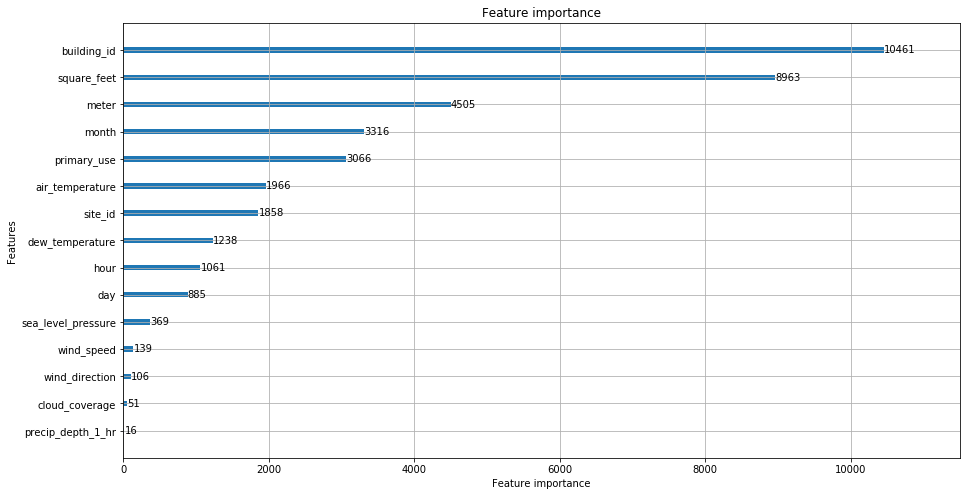

<Figure size 432x288 with 0 Axes>

In [39]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,8))
plt.show()
plt.savefig('lgbm_feature_importance.png')

In [24]:
imp_features = ["building_id","square_feet","meter","month","primary_use","air_temperature","site_id","dew_temperature","hour","day"]

In [25]:
feature_train = feature_train.drop(["cloud_coverage","sea_level_pressure", "wind_direction", "wind_speed","precip_depth_1_hr"], axis = 1)

In [26]:
def rmsle(val_y, y_pred):
    sum=0.0
    for x in range(len(y_pred)):
        if y_pred[x]<0 or val_y[x]<0: #check for negative values
            continue
        p = np.log(y_pred[x]+1)
        r = np.log(val_y[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(y_pred))**0.5

In [27]:
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(feature_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
print(lr.intercept_)

3.0590644928347652


In [29]:
def rmsle(h, y):
    sum =0
    h_list = h.tolist()
    res = np.concatenate(y)
    for i in range(len(h_list)):
        sum = sum + np.square(np.log(h_list[i] + 1) - np.log(res[i] + 1))
    err = np.sqrt(sum/len(h_list))
    return err

In [30]:
feature_validation = feature_validation.drop(["cloud_coverage","sea_level_pressure", "wind_direction", "wind_speed","precip_depth_1_hr"], axis = 1)

In [32]:
from tqdm import tqdm
i=0
y_pred0=[]
step_size = 500 
for j in tqdm(range(int(np.ceil(feature_validation.shape[0]/500)))):
    y_pred0.append(np.expm1(lr.predict(feature_validation.iloc[i:i+step_size])))
    i+=step_size

100%|██████████| 10109/10109 [00:16<00:00, 600.56it/s]


In [47]:
print("rmsle",mean_squared_log_error(target_validation, res1))
print('Coefficients: \n', lr.coef_)

rmsle 7.792960266169392
Coefficients: 
 [-1.66728734e-03 -5.49162850e-02  1.87621367e-01 -3.01981309e-02
  6.49219972e-06 -2.86818874e-04  6.09445594e-03  1.03952721e-02
  1.57079449e-03  2.50368498e-02]


In [40]:
import time

from sklearn.model_selection import KFold
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = True, random_state = None)
error = 0

for fold, (train_index, val_index) in enumerate(kf.split(feature_train, target_train)):
    start = time.time()
    print ('Training FOLD ',fold,'\n')
    print('Train index:','\tfrom:',train_index.min(),'\tto:',train_index.max(),'\n')
    print('Valid index:','\tfrom:',val_index.min(),'\tto:',val_index.max(),'\n')
    
    train_X = feature_train[imp_features].iloc[train_index]
    val_X = feature_train[imp_features].iloc[val_index]
    train_y = target_train.iloc[train_index]
    val_y = target_train.iloc[val_index]
    lgb_train = lightgbm.Dataset(train_X, train_y)
    lgb_eval = lightgbm.Dataset(val_X, val_y)
    
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'num_leaves': 20,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8, 
            'alpha': 0.1, 
            'lambda': 0.1
            }
    
    gbm = lightgbm.train(params,
                lgb_train,
                num_boost_round=2000,
                categorical_feature = imp_features,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 20)

    y_pred = gbm.predict(val_X, num_iteration=gbm.best_iteration)
    
    error += mean_squared_error(val_y, y_pred)/num_folds
#     error += rmsle(val_y, y_pred)/num_folds
    total_time = time.time()-start
    print('\nFold',fold,' Score: ',mean_squared_error(val_y, y_pred))
    print("Total time in second : ", round(total_time,2))
    del train_X, val_X, train_y, val_y, lgb_train, lgb_eval
    gc.collect()

    print (20*'---')
    
print('CV error: ',error)

Training FOLD  0 

Train index: 	from: 0 	to: 15162074 

Valid index: 	from: 6 	to: 15162070 

Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 1.63775	valid_1's rmse: 1.63667
[40]	training's rmse: 1.39577	valid_1's rmse: 1.39448
[60]	training's rmse: 1.29213	valid_1's rmse: 1.29087
[80]	training's rmse: 1.22478	valid_1's rmse: 1.22348
[100]	training's rmse: 1.18088	valid_1's rmse: 1.17966
[120]	training's rmse: 1.14209	valid_1's rmse: 1.14101
[140]	training's rmse: 1.11274	valid_1's rmse: 1.11174
[160]	training's rmse: 1.0931	valid_1's rmse: 1.09219
[180]	training's rmse: 1.07816	valid_1's rmse: 1.07734
[200]	training's rmse: 1.06373	valid_1's rmse: 1.06297
[220]	training's rmse: 1.0498	valid_1's rmse: 1.0491
[240]	training's rmse: 1.03851	valid_1's rmse: 1.03787
[260]	training's rmse: 1.02336	valid_1's rmse: 1.02279
[280]	training's rmse: 1.01484	valid_1's rmse: 1.01434
[300]	training's rmse: 1.00636	valid_1's rmse: 1.00587
[320]	training's rmse: 1.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['air_temperature', 'building_id', 'day', 'dew_temperature', 'hour', 'meter', 'month', 'primary_use', 'site_id', 'square_feet']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 1.63882	valid_1's rmse: 1.63991
[40]	training's rmse: 1.3927	valid_1's rmse: 1.394
[60]	training's rmse: 1.28661	valid_1's rmse: 1.28786
[80]	training's rmse: 1.22604	valid_1's rmse: 1.22731
[100]	training's rmse: 1.17849	valid_1's rmse: 1.17966
[120]	training's rmse: 1.13577	valid_1's rmse: 1.1369
[140]	training's rmse: 1.107	valid_1's rmse: 1.10811
[160]	training's rmse: 1.08807	valid_1's rmse: 1.08915
[180]	training's rmse: 1.06909	valid_1's rmse: 1.07018
[200]	training's rmse: 1.0541	valid_1's rmse: 1.05516
[220]	training's rmse: 1.03868	valid_1's rmse: 1.03969
[240]	training's rmse: 1.02947	valid_1's rmse: 1.03049
[260]	training's rmse: 1.02034	valid_1's rmse: 1.02144
[280]	training's rmse: 1.01243	valid_1's rmse: 1.01352
[300]	training's rmse: 0.999674	valid_1's rmse: 1.00076
[320]	training's rmse: 0.992042	valid_1's rmse: 0.993134
[340]	training's rmse: 0.985002	valid_1's rmse: 0.986103
[360]	tra

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['air_temperature', 'building_id', 'day', 'dew_temperature', 'hour', 'meter', 'month', 'primary_use', 'site_id', 'square_feet']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 1.64388	valid_1's rmse: 1.64336
[40]	training's rmse: 1.39673	valid_1's rmse: 1.39617
[60]	training's rmse: 1.30231	valid_1's rmse: 1.30178
[80]	training's rmse: 1.23003	valid_1's rmse: 1.22957
[100]	training's rmse: 1.18241	valid_1's rmse: 1.182
[120]	training's rmse: 1.14258	valid_1's rmse: 1.14224
[140]	training's rmse: 1.11351	valid_1's rmse: 1.11319
[160]	training's rmse: 1.08389	valid_1's rmse: 1.08356
[180]	training's rmse: 1.06233	valid_1's rmse: 1.06201
[200]	training's rmse: 1.04339	valid_1's rmse: 1.04314
[220]	training's rmse: 1.0291	valid_1's rmse: 1.02895
[240]	training's rmse: 1.01277	valid_1's rmse: 1.0127
[260]	training's rmse: 1.00092	valid_1's rmse: 1.00094
[280]	training's rmse: 0.989257	valid_1's rmse: 0.98928
[300]	training's rmse: 0.976689	valid_1's rmse: 0.976722
[320]	training's rmse: 0.971746	valid_1's rmse: 0.971804
[340]	training's rmse: 0.964216	valid_1's rmse: 0.964237
[360

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['air_temperature', 'building_id', 'day', 'dew_temperature', 'hour', 'meter', 'month', 'primary_use', 'site_id', 'square_feet']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 1.64404	valid_1's rmse: 1.64445
[40]	training's rmse: 1.3968	valid_1's rmse: 1.39764
[60]	training's rmse: 1.28892	valid_1's rmse: 1.29012
[80]	training's rmse: 1.22679	valid_1's rmse: 1.22812
[100]	training's rmse: 1.18095	valid_1's rmse: 1.18232
[120]	training's rmse: 1.14255	valid_1's rmse: 1.14391
[140]	training's rmse: 1.10845	valid_1's rmse: 1.10974
[160]	training's rmse: 1.08878	valid_1's rmse: 1.09007
[180]	training's rmse: 1.07374	valid_1's rmse: 1.07506
[200]	training's rmse: 1.05418	valid_1's rmse: 1.0555
[220]	training's rmse: 1.04197	valid_1's rmse: 1.04334
[240]	training's rmse: 1.03018	valid_1's rmse: 1.03159
[260]	training's rmse: 1.01959	valid_1's rmse: 1.02102
[280]	training's rmse: 1.00836	valid_1's rmse: 1.00979
[300]	training's rmse: 0.99948	valid_1's rmse: 1.00089
[320]	training's rmse: 0.988765	valid_1's rmse: 0.99015
[340]	training's rmse: 0.982038	valid_1's rmse: 0.98347
[360]	t

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['air_temperature', 'building_id', 'day', 'dew_temperature', 'hour', 'meter', 'month', 'primary_use', 'site_id', 'square_feet']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 1.64893	valid_1's rmse: 1.64963
[40]	training's rmse: 1.40483	valid_1's rmse: 1.4057
[60]	training's rmse: 1.29915	valid_1's rmse: 1.30008
[80]	training's rmse: 1.2356	valid_1's rmse: 1.23658
[100]	training's rmse: 1.19142	valid_1's rmse: 1.19245
[120]	training's rmse: 1.1554	valid_1's rmse: 1.15651
[140]	training's rmse: 1.12092	valid_1's rmse: 1.12219
[160]	training's rmse: 1.09802	valid_1's rmse: 1.09943
[180]	training's rmse: 1.07788	valid_1's rmse: 1.07943
[200]	training's rmse: 1.05904	valid_1's rmse: 1.06071
[220]	training's rmse: 1.04607	valid_1's rmse: 1.0478
[240]	training's rmse: 1.03488	valid_1's rmse: 1.0367
[260]	training's rmse: 1.02402	valid_1's rmse: 1.02592
[280]	training's rmse: 1.01397	valid_1's rmse: 1.01593
[300]	training's rmse: 1.00556	valid_1's rmse: 1.00755
[320]	training's rmse: 0.997068	valid_1's rmse: 0.999132
[340]	training's rmse: 0.98727	valid_1's rmse: 0.989391
[360]	tra

In [41]:
from tqdm import tqdm
i=0
y_pred1=[]
step_size = 500 
for j in tqdm(range(int(np.ceil(feature_validation.shape[0]/500)))):
    y_pred1.append(np.expm1(gbm.predict(feature_validation.iloc[i:i+step_size])))
    i+=step_size

100%|██████████| 10109/10109 [07:50<00:00, 21.49it/s]


In [42]:
res = np.concatenate(y_pred1)
l = []
d = []
for i in target_validation:
    d.append(i+1)
for i in res:
    l.append(i+1)

In [44]:

print("rmsle",mean_squared_log_error(d,l))

rmsle 5.513395249528701


In [ ]:
building_df = pd.read_csv("/kaggle/input/ashrae-energy-prediction/building_metadata.csv")
test_df = pd.read_csv("/kaggle/input/ashrae-energy-prediction/test.csv")
weather_test_df = pd.read_csv("/kaggle/input/ashrae-energy-prediction/weather_test.csv")

In [ ]:
building_df = reduce_mem_usage(building_df)
test_df = reduce_mem_usage(test_df)
weather_test_df = reduce_mem_usage(weather_test_df)

In [ ]:
building_merge_test_df = test_df.merge(building_df, on='building_id', how='left')
df_test = building_merge_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

In [ ]:
del test_df
del building_df
del weather_test_df
gc.collect()

In [ ]:
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"])
df_test["hour"] = df_test["timestamp"].dt.hour
df_test["day"] = df_test["timestamp"].dt.day
df_test["month"] = df_test["timestamp"].dt.month

In [ ]:
drop_features = ["timestamp","floor_count","year_built", "cloud_coverage","sea_level_pressure", "wind_direction", "wind_speed","precip_depth_1_hr"]
df_test.drop(drop_features + "row_id", axis=1, inplace=True)

In [ ]:
df_test = reduce_mem_usage(df_test)

In [ ]:
li = ['air_temperature','dew_temperature']
for i in li:
    a = np.round(df_test[i]).median()
    df_test[i] = df_test[i].fillna(a) 


In [ ]:
le = LabelEncoder()
df_test['primary_use'] = le.fit_transform(df_test['primary_use'])

In [ ]:
df_test.isnull().sum(axis = 0)


In [ ]:
df_test = reduce_mem_usage(df_test)

In [ ]:
del feature_train
del feature_validation
del target_train
gc.collect()

In [ ]:
sub = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")


In [ ]:
from tqdm import tqdm
i=0
res=[]
step_size = 5000 
for j in tqdm(range(int(np.ceil(df_test.shape[0]/5000)))):
    res.append(np.expm1(lr.predict(df_test.iloc[i:i+step_size])))

    i+=step_size
res = np.concatenate(res)
sub["meter_reading"] = res
sub.to_csv("submissionlr.csv", index = False)

In [ ]:
i=0
res=[]
step_size = 5000 
for j in tqdm(range(int(np.ceil(df_test.shape[0]/5000)))):
    res.append(np.expm1(gbm.predict(df_test.iloc[i:i+step_size])))

    i+=step_size
res = np.concatenate(res)
sub["meter_reading"] = res
sub.to_csv("submissionlgbm.csv", index = False)

(array([5.68400e+05, 1.83041e+05, 2.76241e+05, 5.48999e+05, 7.90920e+05,
        9.12468e+05, 7.62650e+05, 5.38688e+05, 2.78740e+05, 1.29279e+05,
        4.29880e+04, 1.32280e+04, 5.91700e+03, 1.38900e+03, 6.20000e+01,
        2.32000e+02, 4.20000e+01, 1.05000e+02, 2.76000e+02, 3.60000e+02]),
 array([ 0.        ,  0.84497297,  1.6899459 ,  2.534919  ,  3.3798919 ,
         4.224865  ,  5.069838  ,  5.914811  ,  6.7597837 ,  7.604757  ,
         8.44973   ,  9.294703  , 10.139676  , 10.984649  , 11.829622  ,
        12.674595  , 13.5195675 , 14.364541  , 15.209514  , 16.054487  ,
        16.89946   ], dtype=float32),
 <a list of 20 Patch objects>)

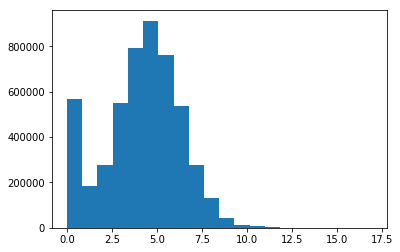

In [45]:
plt.hist(target_validation, bins=20)